In [1]:
import math
import warnings

import numpy as np
import pandas as pd
import scipy
import sklearn
from sklearn import linear_model
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, kstest, boxcox
%matplotlib inline

import itertools
from itertools import chain, combinations
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
from statsmodels.graphics.regressionplots import *
import copy
from sklearn.cross_validation import train_test_split
import time


pd.options.display.float_format = '{:,.3f}'.format

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Grab and process the raw data.
# https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls

data_path = ("Unit_2-Supporting_Files/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.csv"
            )
df_raw = pd.read_csv(data_path, delimiter= ',')


In [3]:
df_raw.head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3,Unnamed: 13
0,Adams Village,"1,861",0,0.000,nan,0,0,0,12,2,10,0,0.000,nan
1,Addison Town and Village,"2,577",3,0.000,nan,0,0,3,24,3,20,1,0.000,nan
2,Akron Village,"2,846",3,0.000,nan,0,0,3,16,1,15,0,0.000,nan
3,Albany,"97,956",791,8.000,nan,30,227,526,"4,090",705,"3,243",142,nan,nan
4,Albion Village,"6,388",23,0.000,nan,3,4,16,223,53,165,5,nan,nan


In [4]:
df_raw.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Unnamed: 13'],
      dtype='object')

In [5]:
# Create new df and Remove rape_1 column and last 3 unwanted rows.
df = df_raw.drop(['Rape\n(revised\ndefinition)1','Unnamed: 13'], axis=1).drop(df_raw.index[-3:]).copy()

In [7]:
# Make a dataframe copy and rename columns
df.rename(columns={'Violent\ncrime':'Violence',
                            'Murder and\nnonnegligent\nmanslaughter':'Murder',
                            'Rape\n(revised\ndefinition)1':'Rape_1',
                            'Rape\n(legacy\ndefinition)2': 'Rape_2',
                            'Aggravated\nassault':'Assault',
                            'Property\ncrime':'Prop_Crime',
                            'Larceny-\ntheft':'Theft',
                            'Motor\nvehicle\ntheft':'MV_Theft'}, inplace=True)

In [8]:
#Pop size squared:

## Remove commas in pop size and robbery numericals
df['Population'] = df.Population.str.replace(',', '')
df['Violence'] = df.Violence.str.replace(',', '')
df['Rape_2'] = df.Rape_2.str.replace(',', '')
df['Robbery'] = df.Robbery.str.replace(',', '')
df['Assault'] = df.Assault.str.replace(',', '')
df['Prop_Crime'] = df.Prop_Crime.str.replace(',', '')
df['Burglary'] = df.Burglary.str.replace(',', '')
df['Theft'] = df.Theft.str.replace(',', '')
df['MV_Theft'] = df.MV_Theft.str.replace(',', '')

## Convert type to int (from string)
df['Population'] = df.Population.astype(int)
df['Violence'] = df.Violence.astype(int)
df['Murder'] = df.Murder.astype(int)
df['Rape_2'] = df.Rape_2.astype(int)
df['Assault'] = df.Assault.astype(int)
df['Robbery'] = df.Robbery.astype(int)
df['Prop_Crime'] = df.Prop_Crime.astype(int)
df['Burglary'] = df.Burglary.astype(int)
df['Theft'] = df.Theft.astype(int)
df['MV_Theft'] = df.MV_Theft.astype(int)

In [9]:
# Create new features: murder to categorical, robbery to catgorical
df['Murder_feat'] = np.where((df['Murder']==0), 0, 1)
df['Robbery_feat'] = np.where((df['Robbery']==0), 0, 1)

## Square & Square Root the Population
df['Population_Sq_feat'] = df.Population * df.Population
df['Population_Sqrt_feat'] = [math.sqrt(x) for x in df.Population]

In [11]:
df[['City','Population','Prop_Crime', 'Murder', 'Theft', 'Population_Sq_feat']].sort_values('Prop_Crime', ascending=False).head()

,City,Population,Prop_Crime,Murder,Theft,Population_Sq_feat
216,New York,8396126,141971,335,117931,70494931807876
35,Buffalo,258789,12491,47,8076,66971746521
272,Rochester,210562,10051,42,6855,44336355844
310,Syracuse,143834,6473,21,4298,20688219556
3,Albany,97956,4090,8,3243,9595377936


In [12]:
#Creating a variable that drops the outlier city of New York.
df_drop_nyc =  df[df.City != 'New York']

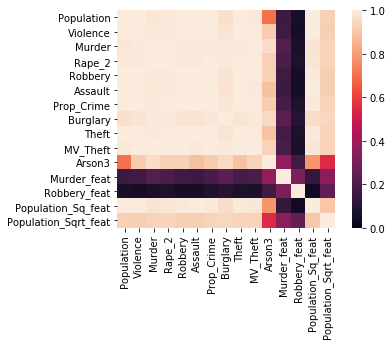

                      Population  Violence  Murder  Rape_2  Robbery  Assault  \
Population                 1.000     0.999   0.987   0.991    0.998    0.999   
Violence                   0.999     1.000   0.992   0.995    1.000    1.000   
Murder                     0.987     0.992   1.000   0.998    0.993    0.991   
Rape_2                     0.991     0.995   0.998   1.000    0.995    0.994   
Robbery                    0.998     1.000   0.993   0.995    1.000    1.000   
Assault                    0.999     1.000   0.991   0.994    1.000    1.000   
Prop_Crime                 0.996     0.998   0.995   0.998    0.998    0.998   
Burglary                   0.971     0.978   0.994   0.992    0.980    0.976   
Theft                      0.998     0.999   0.993   0.996    0.999    0.999   
MV_Theft                   0.992     0.996   0.998   0.999    0.997    0.995   
Arson3                     0.702     0.918   0.963   0.926    0.932    0.888   
Murder_feat                0.162     0.1

In [13]:
corrmat = df.corr()
corrmat_drop_nyc = df_drop_nyc.corr()

# Heatmap with all cities
sns.heatmap(corrmat, vmin=0, vmax=1, square=True)
plt.show()

print(corrmat)

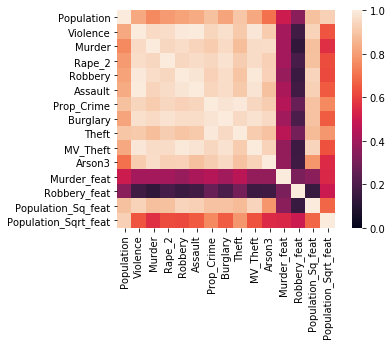

                      Population  Violence  Murder  Rape_2  Robbery  Assault  \
Population                 1.000     0.829   0.756   0.797    0.816    0.835   
Violence                   0.829     1.000   0.955   0.962    0.994    0.997   
Murder                     0.756     0.955   1.000   0.946    0.963    0.938   
Rape_2                     0.797     0.962   0.946   1.000    0.949    0.958   
Robbery                    0.816     0.994   0.963   0.949    1.000    0.983   
Assault                    0.835     0.997   0.938   0.958    0.983    1.000   
Prop_Crime                 0.887     0.944   0.917   0.949    0.933    0.942   
Burglary                   0.820     0.971   0.956   0.974    0.964    0.964   
Theft                      0.901     0.913   0.881   0.921    0.898    0.913   
MV_Theft                   0.828     0.987   0.959   0.960    0.989    0.977   
Arson3                     0.702     0.918   0.963   0.926    0.932    0.888   
Murder_feat                0.503     0.4

In [15]:
# Heatmap without NYC
sns.heatmap(corrmat_drop_nyc, vmin=0, vmax=1, square=True)
plt.show()

print(corrmat_drop_nyc)

In [23]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['Prop_Crime']
X = df[['Population', 'Theft', 'Murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [-3.30443286e-03  1.28981008e+00  5.25901928e+01]

Intercept: 
 20.915651835762446

R-squared:
0.9999151673695925


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


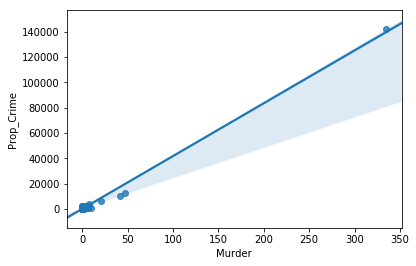

In [19]:
sns.regplot(df.Murder, df.Prop_Crime)

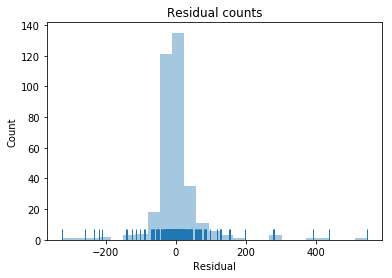

In [24]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = df['Prop_Crime']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
sns.distplot(residual, kde=False, rug=True, bins=25)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

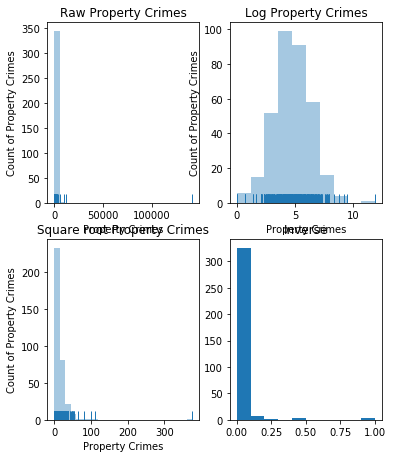

In [25]:
# Checking out the distribution of the independent variable: TV
fig = plt.figure()
plt.subplots_adjust(left=None, bottom=-.5, right=None, top=None, wspace=None, hspace=None)

fig.add_subplot(221)
sns.distplot(df['Prop_Crime'], kde=False, rug=True, bins=25)
plt.title('Raw Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

fig.add_subplot(222)
sns.distplot(np.log(df['Prop_Crime'][df.Prop_Crime != 0]),kde=False, rug=True, bins=10)
plt.title('Log Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

fig.add_subplot(223)
sns.distplot(np.sqrt(df['Prop_Crime']),kde=False, rug=True, bins=25)
plt.title('Square root Property Crimes')
plt.xlabel('Property Crimes')
plt.ylabel('Count of Property Crimes')

# ax3=fig.add_subplot(224)
# Box Cox Transformation:
# http://www.kmdatascience.com/2017/07/box-cox-transformations-in-python.html

# Transform_Prop_Crime = np.asarray(df['Prop_Crime'][df.Prop_Crime != 0].values)

# # transform values and store as "sales_boxcox"
# Prop_Crime_boxcox = boxcox(Transform_Prop_Crime)[0]

# # # create the boxcox_sales transformed variable:
# df['Prop_Crime_boxcox'] = Prop_Crime_boxcox

# print(df.Prop_Crime_boxcox.unique())

# # plot the transformed box cox data
ax3=fig.add_subplot(224)
plt.hist(1/df['Prop_Crime'][df.Prop_Crime != 0])
plt.title('Inverse')
plt.show()

# plt.show()

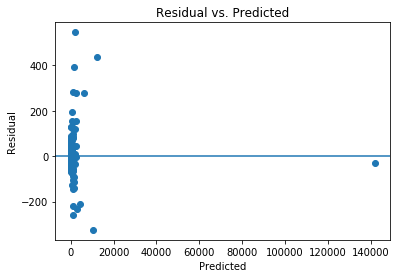

In [26]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

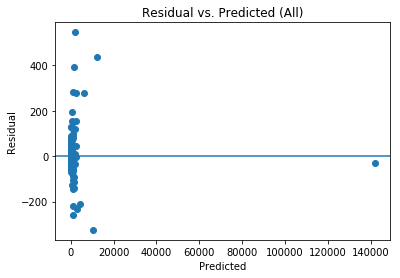

In [45]:
lm_all = smf.ols(formula = "Prop_Crime ~ Population + Murder +Theft", data = df).fit()

resid = lm_all.resid
plt.scatter(lm_all.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (All)')
plt.show()
plt.show()

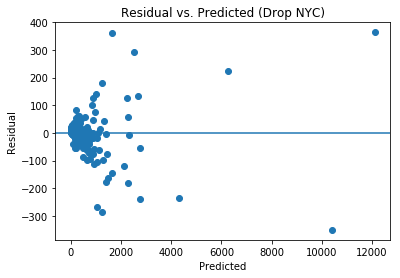

In [46]:
lm_drop_nyc = smf.ols(formula = "Prop_Crime ~ Population + Murder +Theft", data = df_drop_nyc).fit()

resid = lm_drop_nyc.resid
plt.scatter(lm_drop_nyc.predict(), resid)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted (Drop NYC)')
plt.show()

In [20]:
lm = smf.ols(formula = "Prop_Crime ~ Population", data = df).fit()
print(lm.summary())

elem1res = pd.concat([df, pd.Series(lm.resid, name = 'resid'), pd.Series(lm.predict(), name = "predict")], axis = 1)

                            OLS Regression Results                            
Dep. Variable:             Prop_Crime   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                 4.606e+04
Date:                Fri, 16 Nov 2018   Prob (F-statistic):               0.00
Time:                        08:17:14   Log-Likelihood:                -2753.3
No. Observations:                 348   AIC:                             5511.
Df Residuals:                     346   BIC:                             5518.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    113.7030     35.646      3.190      0.0

### Writeup

#### Assumption one: linear relationship
Using the raw variables Population, Theft, and Murder produce an R-Squared of 99.9% and thus, virtually all of the variance Property Crimes.

Looking at the coefficients, there's a intercept of 20.9, which indicates that Property Crimes would happen with the other crimes of Population, Theft, and Murder happening. Murder has the highest per Property Crime increase on with 5.3 per Property Crime.

#### Assumption two: multivariate normality
The error from the model (calculated by subtracting the model-predicted values from the real outcome values) should is normally distributed, with a very high reversion to the mean.

Initially, despite the City of New York being an large outlier, it actually maps well along the line of best fit amongst the different crime variables. Dropping New York actually resulted in less accuracy and weaker linear relationship.

While transforming the data to log more evenly distributes the data, the raw distribution is sufficient enough, with an understanding of the high reversion to the mean.

#### Assumption three: homoscedasticity
At first glance, the errors seem to not be consistently distributed. The scale of the scatter plot is framing this view, and removing NYC illustrates that the rest of the data is more consistently distributed.

The larger value of NYC is still consistent with the other errors, however just much larger.

#### Assumption four: low multicollinearity¶
Colinarity is actually too high among the crime variables and I would recommend dropping the Theft variable.